<a href="https://colab.research.google.com/github/slachitoff/Music-Source-Separation/blob/main/Music_Source_Separation_with_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install musdb
!pip install mir_eval

import musdb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from torchsummary import summary
import random
import gc
import torch.multiprocessing as mp
import numpy as np
import os
import logging
import h5py
import matplotlib.pyplot as plt
import mir_eval
from torch.utils.data._utils.collate import default_collate
from torch.nn.utils.rnn import pad_sequence
mp.set_start_method('spawn', force=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 877.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mir_eval: filename=mir_eval-0.7-py3-none-any.whl size=100704 sha256=70de0d635f1a7b3b4a2b9ddbdfd45db3cb9ba6206b14410468d6389ad34fd432
  Stored in directory: /root/.cache/pip/wheels/3e/2f/0d/dda9c4c77a170e21356b6afa2f7d9bb078338634ba05d94e3f
Successfully built mir_eval


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
mus = musdb.DB(root='/content/drive/MyDrive/musdb18', subsets='train', split='train')

The `SpectrogramPreprocessor` class takes tracks from the MUSDB10 dataset and transforms them into complex spectrograms, normalizes them, and saves the spectrograms to a directory.

In [ ]:
class SpectrogramPreprocessor:
    def __init__(self, musdb, chunk_duration=6, target_sr=22050, original_sr=44100, transform=None, debug=False, save_dir=None):
        assert isinstance(chunk_duration, int) and chunk_duration > 0, "chunk_duration must be a positive integer"
        assert isinstance(target_sr, int) and target_sr > 0, "target_sr must be a positive integer"
        assert isinstance(original_sr, int) and original_sr > 0, "original_sr must be a positive integer"

        self.musdb = musdb.tracks  # List of tracks from the MUSDB18 dataset
        self.chunk_duration = chunk_duration  # Duration of each audio chunk
        self.target_sr = target_sr  # Target sample rate for resampling
        self.chunk_length = self.target_sr * self.chunk_duration  # Length of each chunk in samples
        self.original_sr = original_sr  # Original sample rate of the audio
        self.transform = transform  # Optional transform to apply to spectrograms
        self.debug = debug  # Debug flag
        self.save_dir = save_dir or os.path.join(musdb.root, 'spectrograms')  # Directory to save spectrograms
        os.makedirs(self.save_dir, exist_ok=True)  # Create save directory if it doesn't exist
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Set device to GPU if available

    # Normalizes a spectrogram's magnitude
    def normalize_magnitude(self, spec, lower_percentile=5, upper_percentile=95):
        magnitude = torch.abs(spec)  # Get magnitude of the spectrogram
        phase = torch.angle(spec)  # Get phase of the spectrogram
        dynamic_range = magnitude.max() - magnitude.min()  # Compute dynamic range

        if dynamic_range < 1e-8:
            return spec  # Return original spectrogram if dynamic range is too small

        epsilon = 1e-6  # Small value for numerical stability
        magnitude = torch.log1p(magnitude + epsilon)  # Log scale transformation

        lower_bound = torch.quantile(magnitude, lower_percentile / 100.0)  # Compute lower bound
        upper_bound = torch.quantile(magnitude, upper_percentile / 100.0)  # Compute upper bound
        if upper_bound <= lower_bound:
            return spec  # Return original spectrogram if bounds are invalid

        # Normalize the magnitude
        normalized_magnitude = torch.clip((magnitude - lower_bound) / (upper_bound - lower_bound), 0, 1)
        normalized_spec = torch.polar(normalized_magnitude, phase)  # Recombine normalized magnitude with original phase

        return normalized_spec

    # Resamples audio and converts to mono
    def resample_audio(self, audio_np, original_sr, target_sr):
        if audio_np.shape[1] > audio_np.shape[0]:
            audio_tensor = torch.from_numpy(audio_np).float()  # Convert to tensor
        else:
            audio_tensor = torch.from_numpy(audio_np.T).float()  # Transpose if needed
        if original_sr != target_sr:
            resampler = torchaudio.transforms.Resample(original_sr, target_sr)  # Resample audio
            audio_tensor = resampler(audio_tensor)
        if audio_tensor.shape[0] > 1:
            audio_tensor = torch.mean(audio_tensor, dim=0, keepdim=True)  # Convert to mono if multi-channel
        return audio_tensor

    # Process each audio file into chunks and compute the spectrograms.
    def process_audio_file(self, track):
        audio = torch.tensor(track.audio.T, dtype=torch.float32)  # Convert audio to tensor

        if self.original_sr != track.rate:
            raise ValueError(f"Track {track.name} has a different sampling rate: {track.rate}. Expected: {self.original_sr}")

        num_chunks = max(1, audio.shape[1] // self.chunk_length)  # Calculate number of chunks

        for chunk_idx in range(num_chunks):
            start = chunk_idx * self.chunk_length  # Start index of the chunk
            end = min(audio.shape[1], start + self.chunk_length)  # End index of the chunk
            audio_chunk = audio[:, start:end]  # Extract audio chunk

            mixed_spectrogram = self.compute_and_save_spectrogram(track.name, chunk_idx, audio_chunk)  # Compute spectrogram

            if torch.is_complex(mixed_spectrogram):
                mixed_spectrogram = torch.view_as_real(mixed_spectrogram)  # Convert complex spectrogram to real

            print(f"Chunk Index: {chunk_idx}")
            print(f"Mixed Spectrogram Shape: {mixed_spectrogram.shape}")

            for source_name, source in track.sources.items():
                source_audio_chunk = torch.tensor(source.audio[start:end].T, dtype=torch.float32)  # Extract source audio chunk
                source_spectrogram = self.compute_and_save_spectrogram(track.name, chunk_idx, source_audio_chunk, source_name)  # Compute source spectrogram

                if torch.is_complex(source_spectrogram):
                    source_spectrogram = torch.view_as_real(source_spectrogram)  # Convert complex spectrogram to real

                print(f"Source: {source_name}, Source Spectrogram Shape: {source_spectrogram.shape}")

    # Compute and save a spectrogram for a given audio file and chunk index.
    def compute_and_save_spectrogram(self, track_name, chunk_idx, audio_chunk, source_name=None):
        base_filename = f"{track_name}_chunk{chunk_idx}"  # Base filename for saving
        spectrogram_path = os.path.join(self.save_dir, f"{base_filename}_{'mixed' if source_name is None else source_name}_source.pt")  # Path to save spectrogram

        try:
            audio_chunk = self.resample_audio(audio_chunk.numpy(), self.original_sr, self.target_sr)  # Resample audio
            spectrogram = self.audio_to_complex_spectrogram(audio_chunk)  # Compute spectrogram

            if spectrogram.dim() > 3 and spectrogram.size(0) == 1:
                spectrogram = spectrogram.squeeze(0)  # Squeeze dimension if needed
            torch.save(spectrogram, spectrogram_path)  # Save spectrogram
            return spectrogram
        except Exception as e:
            print(f"Failed to compute or save spectrogram for {track_name}: {str(e)}")  # Print error message
            return None

    # Compute a complex spectrogram from an audio signal.
    def audio_to_complex_spectrogram(self, audio, n_fft=1024, hop_length=512):
        if not isinstance(audio, torch.Tensor):
            audio = torch.tensor(audio, dtype=torch.float32)  # Convert to tensor if not already
        audio = audio.to(self.device)  # Move audio to device

        if audio.size(1) < audio.size(0):
            audio = audio.transpose(0, 1)  # Transpose if needed

        if audio.size(1) < n_fft:
            padding = n_fft - audio.size(1)  # Compute padding
            audio = F.pad(audio, (0, padding), "constant", 0)  # Pad audio

        if audio.abs().max().item() < 1e-8:
            return torch.zeros((1, n_fft // 2 + 1, max(1, audio.size(1) // hop_length + 1)), dtype=torch.cfloat, device=self.device)  # Return zero tensor if audio is silent

        window = torch.hann_window(n_fft, device=self.device)  # Hann window for STFT
        complex_spec = torch.stft(audio, n_fft=n_fft, hop_length=hop_length, window=window, return_complex=True)  # Compute STFT

        normalized_spec = self.normalize_magnitude(complex_spec)  # Normalize spectrogram

        return normalized_spec

    # Precompute and save spectrograms for all audio files in the folder.
    def precompute_spectrograms(self):
        for track in self.musdb:
            print(f"Processing track {track.name}")  # Print track being processed
            self.process_audio_file(track)  # Process each track


In [ ]:
# Converts a set of .pt files to HDF5 format for fast access
def convert_pt_to_hdf5(pt_dir, hdf5_file):
    # Create a new HDF5 file
    with h5py.File(hdf5_file, 'w') as hdf5:
        # Loop through all .pt files in the directory
        for filename in os.listdir(pt_dir):
            if filename.endswith('.pt'):
                # Construct the full file path
                filepath = os.path.join(pt_dir, filename)
                # Load the data from the .pt file
                data = torch.load(filepath)
                # Ensure the data is on CPU
                data = data.cpu()
                # Use the filename without the extension as the dataset name
                dataset_name = filename[:-3]
                # Convert the torch tensor to numpy and save to HDF5
                hdf5.create_dataset(dataset_name, data=data.numpy(), compression="gzip")

The `SpectrogramTransforms` class applies various data augmentation techniques to spectrograms.
It includes time masking, frequency masking, noise addition, and spectrogram augmentation through random time and frequency
stripes dropping.

In [ ]:
class SpectrogramTransforms:
    def __init__(self,
                 p_time_mask=0.5,
                 p_freq_mask=0.5,
                 time_mask_param=40,
                 freq_mask_param=40,
                 time_stripes_num=3,
                 freq_stripes_num=3,
                 p_add_noise=0.5,
                 min_snr_db=10,
                 max_snr_db=30,
                 p_time_warp=0.3,
                 time_warp_param=80):

        # Probability of applying time masking
        self.p_time_mask = p_time_mask
        # Probability of applying frequency masking
        self.p_freq_mask = p_freq_mask
        # Parameters for time and frequency masking from torchaudio
        self.time_masking = T.TimeMasking(time_mask_param)
        self.freq_masking = T.FrequencyMasking(freq_mask_param)
        # Number of time and frequency stripes to drop in spec_augment
        self.time_stripes_num = time_stripes_num
        self.freq_stripes_num = freq_stripes_num
        # Probability of adding noise
        self.p_add_noise = p_add_noise
        # Minimum and maximum Signal-to-Noise Ratio (SNR) for added noise
        self.min_snr_db = min_snr_db
        self.max_snr_db = max_snr_db

    def __call__(self, spec):
        # Apply time masking with a given probability
        if random.random() < self.p_time_mask:
            spec = self.time_masking(spec)
        # Apply frequency masking with a given probability
        if random.random() < self.p_freq_mask:
            spec = self.freq_masking(spec)
        # Add noise with a given probability
        if random.random() < self.p_add_noise:
            spec = self.add_noise(spec)
        # Apply spectrogram augmentation
        return self.spec_augment(spec)

    def add_noise(self, spec):
        # Select a random SNR value within the specified range
        snr_db = random.uniform(self.min_snr_db, self.max_snr_db)
        # Calculate the amplitude of the noise
        noise_amp = spec.abs().max() / (10 ** (snr_db / 20))
        # Generate noise with the same shape as the spectrogram
        noise = torch.randn_like(spec) * noise_amp
        # Add noise to the spectrogram
        return spec + noise

    def time_warp(self, spec):
        # Get the number of time steps in the spectrogram
        time_steps = spec.size(-1)
        if time_steps > self.time_warp_param:
            # Select a random center point for time warping
            center = random.randint(self.time_warp_param, time_steps - self.time_warp_param)
            # Create a copy of the spectrogram
            warped = spec.clone()
            # Warp the time axis around the center point
            warped[:, :, center - self.time_warp_param:center + self.time_warp_param] = \
                spec[:, :, center - self.time_warp_param // 2:center + self.time_warp_param // 2]
            return warped
        return spec

    def spec_augment(self, spec):
        # Get the dimensions of the spectrogram
        time_dim, freq_dim = spec.size(-1), spec.size(-2)
        # Determine the width of time and frequency drops
        time_drop_width = max(1, min(time_dim // 10, time_dim - 1))
        freq_drop_width = max(1, min(freq_dim // 10, freq_dim - 1))

        # Drop random time stripes in the spectrogram
        for _ in range(self.time_stripes_num):
            start = random.randint(0, time_dim - time_drop_width)
            end = start + time_drop_width
            spec[..., start:end] = 0

        # Drop random frequency stripes in the spectrogram
        for _ in range(self.freq_stripes_num):
            start = random.randint(0, freq_dim - freq_drop_width)
            end = start + freq_drop_width
            spec[..., :, start:end] = 0

        return spec



The `AudioDataset` class represents a custom dataset for handling audio data stored in an HDF5 file.
It loads mixed and source spectrograms for a given list of tracks, with the option of applying the previously defined transformations.


In [ ]:
class AudioDataset(Dataset):
    def __init__(self, hdf5_path, track_list, transform=None):
       # Path to the HDF5 file containing the dataset
        self.hdf5_path = hdf5_path
        # List of tracks to be loaded from the HDF5 file
        self.track_list = track_list
        # Optional transform to be applied to the spectrograms
        self.transform = transform
        # Open the HDF5 file for reading
        self.hdf5_file = h5py.File(self.hdf5_path, 'r')

    def __getitem__(self, idx):
        # Get the base name of the track at the given index
        track_base = self.track_list[idx]
        # List of source instruments
        sources = ['bass', 'drums', 'other', 'vocals']
        # Construct the name for the mixed spectrogram in the HDF5 file
        mixed_name = f"{track_base}_mixed_source"
        # Load and convert the mixed spectrogram from the HDF5 file
        mixed_spectrogram = torch.view_as_real(torch.from_numpy(self.hdf5_file[mixed_name][()]))

        # Apply the optional transform to the mixed spectrogram
        if self.transform:
            mixed_spectrogram = self.transform(mixed_spectrogram)

        # Create a list to store the source spectrograms
        source_spectrograms = []
        for source in sources:
            # Construct the name for the source spectrogram in the HDF5 file
            full_name = f"{track_base}_{source}_source"
            # Load and convert the source spectrogram from the HDF5 file
            complex_array = self.hdf5_file[full_name][()]
            tensor = torch.view_as_real(torch.from_numpy(complex_array))
            # Apply the optional transform to the source spectrogram
            if self.transform:
                tensor = self.transform(tensor)
            # Add the transformed source spectrogram to the list
            source_spectrograms.append(tensor)

        # Concatenate all source spectrograms along the channel dimension
        source_spectrograms = torch.cat(source_spectrograms, dim=0)

        # Return the mixed spectrogram and the concatenated source spectrograms
        return mixed_spectrogram, source_spectrograms

    def __len__(self):
        # Return the number of tracks in the dataset
        return len(self.track_list)

    def close(self):
        # Close the HDF5 file if it is open
        if hasattr(self, 'hdf5_file') and self.hdf5_file:
            self.hdf5_file.close()

    def __del__(self):
        # Ensure the HDF5 file is closed when the object is deleted
        self.close()

Pads and collates a batch of data and targets to the maximum height and width in the batch.

In [ ]:
def pad_and_collate(batch):

    # Find the maximum height and width in the batch for both data and targets
    max_height = max(max(data.size(2), targets.size(2)) for data, targets in batch)
    max_width = max(max(data.size(3), targets.size(3)) for data, targets in batch)

    padded_batch = []
    for data, targets in batch:
        # Calculate the padding needed for the data tensor to match the maximum width and height
        data_padding = (0, max_width - data.size(3), 0, max_height - data.size(2))
        # Apply padding to the data tensor
        padded_data = F.pad(data, data_padding, "constant", 0)

        # Calculate the padding needed for the targets tensor to match the maximum width and height
        target_padding = (0, max_width - targets.size(3), 0, max_height - targets.size(2))
        # Apply padding to the targets tensor
        padded_targets = F.pad(targets, target_padding, "constant", 0)

        # Append the padded data and targets as a tuple to the padded batch
        padded_batch.append((padded_data, padded_targets))

    # Use the default collate function to convert the list of padded tuples into a batch tensor
    return default_collate(padded_batch)


Retrieves a sorted list of unique track base names from an HDF5 file.

In [ ]:
def get_unique_track_names(hdf5_path):
    # Open the HDF5 file
    with h5py.File(hdf5_path, 'r') as file:
        # Retrieve keys from the HDF5 file
        keys = list(file.keys())

    # Extract base names by splitting each key
    base_names = set(key.rsplit('_', 2)[0] for key in keys)

    # Return the sorted list of unique base names
    return sorted(base_names)

In [ ]:
# Initialize the spectrogram transformations with specified probabilities and parameters
transform = SpectrogramTransforms(
    p_time_mask=0.25,
    p_freq_mask=0.25,
    time_mask_param=20,
    freq_mask_param=20,
    time_stripes_num=3,
    freq_stripes_num=3,
    p_add_noise=0.25,
    min_snr_db=10,
    max_snr_db=20,
    p_time_warp=0.3,
    time_warp_param=80
)


# Define the path to the HDF5 file
hdf5_path = '/content/drive/MyDrive/musdb18/custom_spectrograms_hdf5'

# Get the list of unique track base names from the HDF5 file
track_names = get_unique_track_names(hdf5_path)

# Determine the total number of tracks to use
total_tracks = min(100, len(track_names))  # Reduce for testing

# Generate a list of indices for the tracks and shuffle them
indices = list(range(total_tracks))
random.shuffle(indices)

# Split the indices into training and validation sets
split_ratio = 0.9
split_idx = int(max(1, total_tracks * split_ratio))
train_track_names = [track_names[i] for i in indices[:split_idx]]
valid_track_names = [track_names[i] for i in indices[split_idx:]]

# Create training and validation datasets with the corresponding track names and transformations
train_dataset = AudioDataset(hdf5_path=hdf5_path, track_list=train_track_names, transform=None)  # Disable transform for testing
valid_dataset = AudioDataset(hdf5_path=hdf5_path, track_list=valid_track_names)

# Set the batch size for data loading
batch_size = 6  # Reduce batch size for testing

# Create DataLoader for the training dataset
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    collate_fn=pad_and_collate
)

# Create DataLoader for the validation dataset
valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    collate_fn=pad_and_collate
)

In [ ]:
#Initializes the weights of convolutional and transposed convolutional layers using Kaiming normal initialization, and initializes biases to zero.
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

#Initializes a complex convolutional block for real and imaginary channels.
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3, 3), padding=1, use_residual=True, dropout_prob=0.5):
        super(ConvBlock, self).__init__()
        self.use_residual = use_residual and in_channels == out_channels  # Use residual connections if specified and channels match
        self.conv_real = nn.Conv2d(in_channels // 2, out_channels // 2, kernel_size, padding=padding)  # Real part convolution
        self.conv_imag = nn.Conv2d(in_channels // 2, out_channels // 2, kernel_size, padding=padding)  # Imaginary part convolution
        self.bn = nn.BatchNorm2d(out_channels)  # Batch normalization
        self.dropout = nn.Dropout2d(dropout_prob)  # Dropout for regularization
        self.conv_real.apply(init_weights)  # Initialize weights for real part convolution
        self.conv_imag.apply(init_weights)  # Initialize weights for imaginary part convolution

    #Defines forward pass for the convolutional block.
    def forward(self, x):
        real = x[:, :x.shape[1]//2, :, :]  # Split input tensor into real part
        imag = x[:, x.shape[1]//2:, :, :]  # Split input tensor into imaginary part
        real_updated = self.conv_real(real) - self.conv_imag(imag)  # Apply convolution and combine real and imaginary parts
        imag_updated = self.conv_imag(real) + self.conv_real(imag)  # Apply convolution and combine real and imaginary parts
        x_updated = torch.cat((real_updated, imag_updated), dim=1)  # Concatenate real and imaginary parts
        x_updated = self.bn(x_updated)  # Apply batch normalization
        x_updated = self.dropout(x_updated)  # Apply dropout
        if self.use_residual:  # Check if residual connections are used
            x_updated += x  # Add input to output for residual connection
        return F.leaky_relu(x_updated)  # Apply leaky ReLU activation

#Initializes the encoder block.
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks=3, dropout_prob=0.5):
        super(Encoder, self).__init__()
        self.initial_conv = ConvBlock(in_channels, out_channels, dropout_prob=dropout_prob)  # Initial convolutional block
        self.layers = nn.ModuleList([  # List of subsequent convolutional blocks
            ConvBlock(out_channels, out_channels, dropout_prob=dropout_prob) for _ in range(num_blocks - 1)
        ])
        self.pool = nn.MaxPool2d((2, 2))  # Max pooling layer
        self.apply(init_weights)  # Initialize weights for all layers

    #Defines forward pass for the encoder block.
    def forward(self, x):
        x = self.initial_conv(x)  # Apply initial convolutional block
        for layer in self.layers:  # Apply each subsequent convolutional block
            x = layer(x)
        x_pooled = self.pool(x)  # Apply max pooling
        return x, x_pooled  # Return the feature maps and the pooled output

#Initializes the decoder block.
class Decoder(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels, num_blocks=2, dropout_prob=0.5):
        super(Decoder, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=(2, 2), stride=(2, 2))  # Transposed convolutional layer
        self.layers = nn.ModuleList([  # List of convolutional blocks
            ConvBlock(out_channels + skip_channels, out_channels, dropout_prob=dropout_prob) if i == 0
            else ConvBlock(out_channels, out_channels, dropout_prob=dropout_prob)
            for i in range(num_blocks)
        ])
        self.apply(init_weights)  # Initialize weights for all layers

    #Defines forward pass for the decoder block.
    def forward(self, x, skip):
        x = self.upconv(x)  # Apply transposed convolution to upsample
        if x.size()[2:] != skip.size()[2:]:  # If the sizes don't match
            x = F.interpolate(x, size=skip.size()[2:], mode='nearest')  # Resize using nearest neighbor interpolation
        x = torch.cat([x, skip], dim=1)  # Concatenate with the skip connection
        for layer in self.layers:  # Apply each convolutional block
            x = layer(x)
        return x  # Return the output

#Initializes the U-Net model with encoder and decoder blocks, and a final convolutional layer.
class EnhancedUNet(nn.Module):
    def __init__(self, in_channels=2, num_sources=4, dropout_prob=0.5):
        super(EnhancedUNet, self).__init__()
        self.enc1 = Encoder(in_channels, 64, dropout_prob=dropout_prob)
        self.enc2 = Encoder(64, 128, dropout_prob=dropout_prob)
        self.enc3 = Encoder(128, 256, dropout_prob=dropout_prob)
        self.bottleneck = ConvBlock(256, 512, dropout_prob=dropout_prob)
        self.dec3 = Decoder(512, 256, 256, dropout_prob=dropout_prob)
        self.dec2 = Decoder(256, 128, 128, dropout_prob=dropout_prob)
        self.dec1 = Decoder(128, 64, 64, dropout_prob=dropout_prob)
        self.final_conv = nn.Conv2d(64, num_sources * 2, kernel_size=(1, 1))
        self.apply(init_weights)

    def forward(self, x):
        # Forward pass through the encoder
        x1, x = self.enc1(x)
        x2, x = self.enc2(x)
        x3, x = self.enc3(x)


        # Bottleneck
        x = self.bottleneck(x)

        # Forward pass through the decoder

        x = self.dec3(x, x3)
        x = self.dec2(x, x2)
        x = self.dec1(x, x1)

        # Final convolution to match the number of output channels
        x = self.final_conv(x)

        # Reshape the output to have separate dimensions for sources and real/imaginary parts
        x = x.view(x.size(0), 4, 2, x.size(2), x.size(3))

        return x



In [ ]:
# Computes the L1 loss between the high-pass filtered versions of the output and target.
def high_pass_filter_loss(output, target, cutoff_freq=3000, sample_rate=22050, epsilon=1e-8):
    # Apply high-pass filter to the output and target
    high_pass_output = torchaudio.functional.highpass_biquad(output + epsilon, sample_rate, cutoff_freq)
    high_pass_target = torchaudio.functional.highpass_biquad(target + epsilon, sample_rate, cutoff_freq)
    # Compute L1 loss between the filtered outputs
    loss = F.l1_loss(high_pass_output, high_pass_target)
    return loss

# Computes the mean squared error (MSE) loss between the phases of the output and target.
def phase_loss(output, target, epsilon=1e-8):
    if output.shape == target.shape:
        # Compute phase angles of the output and target
        phase_output = torch.angle(output + epsilon)
        phase_target = torch.angle(target + epsilon)
        # Compute mean squared error loss between the phase angles
        loss = F.mse_loss(phase_output, phase_target)
    else:
        # Return a small loss value if shapes do not match
        loss = torch.tensor(epsilon, device=output.device)
    return loss

# Computes the spectral convergence loss between the output and target.
def spectral_convergence_loss(output, target, epsilon=1e-8):
    # Compute Frobenius norms of the target and difference between target and output
    norm_target = torch.norm(target, p='fro', dim=[-2, -1]) + epsilon
    norm_diff = torch.norm(target - output, p='fro', dim=[-2, -1])
    # Compute spectral convergence loss
    loss = norm_diff / norm_target
    # Mask loss values for non-zero targets
    mask = torch.any(target != 0, dim=[-2, -1])
    masked_loss = loss * mask.to(loss.dtype)
    # Compute normalized loss
    if mask.any():
        normalized_loss = masked_loss.sum() / mask.sum()
    else:
        normalized_loss = torch.tensor(0.0, device=loss.device).float()
    return normalized_loss

# Computes the L1 loss between the magnitudes of the output and target.
def magnitude_loss(output, target):
    # Compute magnitudes of the output and target
    mag_output = torch.abs(output)
    mag_target = torch.abs(target)
    # Compute L1 loss between the magnitudes
    loss = F.l1_loss(mag_output, mag_target)
    return loss

# Computes the mean squared error loss for interference between sources.
def interference_loss(outputs, targets, epsilon=1e-8):
    # Get the dimensions of the outputs tensor
    batch_size, num_sources, freq_bins, time_frames = outputs.shape
    # Initialize the total interference loss to zero
    total_interference_loss = torch.tensor(0.0, device=outputs.device)

    # Iterate over each source pair
    for i in range(num_sources):
        for j in range(num_sources):
            if i != j:  # Skip if both indices are the same
                # Calculate the absolute difference between the predicted and ground truth spectrograms
                interference = torch.abs(outputs[:, i] - targets[:, j])
                # Check if the interference tensor is empty
                if interference.numel() == 0:
                    print(f"Empty interference tensor for sources {i} and {j}")
                    return None

                # Calculate the mean squared error loss without reduction
                interference_loss = F.mse_loss(interference, torch.zeros_like(interference), reduction='none')
                # Sum the loss over the frequency and time dimensions
                interference_loss = interference_loss.sum(dim=(1, 2))
                # Normalize the loss by the number of frequency bins and time frames
                interference_loss = interference_loss / (freq_bins * time_frames + epsilon)
                # Add the mean interference loss to the total interference loss
                total_interference_loss += interference_loss.mean()

    # Average the total interference loss over the batch size
    total_interference_loss /= batch_size

    # Return the total interference loss if it's not empty, otherwise return None
    return total_interference_loss if total_interference_loss.numel() != 0 else None

# Computes a custom loss as a weighted sum of different loss components.
def custom_loss(outputs, targets, weights, sample_rate=22050, cutoff_freq=3000, epsilon=1e-8):
    # Extract weights for different loss components
    spec_weight = weights['spec_weight']
    mag_weight = weights['mag_weight']
    phase_weight = weights['phase_weight']
    interference_weight = weights['interference_weight']
    artifacts_weight = weights['artifacts_weight']

    # Initialize total loss
    total_loss = torch.tensor(0.0, device=outputs.device)
    for output, target in zip(outputs, targets):

        # Compute individual loss components
        spec_loss = spectral_convergence_loss(output, target)
        mag_loss = magnitude_loss(output, target)
        phs_loss = phase_loss(output, target)
        intr_loss = interference_loss(output, target)
        art_loss = high_pass_filter_loss(output, target, cutoff_freq=cutoff_freq, sample_rate=sample_rate)

        # Ensure loss values are tensors
        spec_loss = spec_loss if torch.is_tensor(spec_loss) else torch.tensor(spec_loss, device=outputs.device)
        mag_loss = mag_loss if torch.is_tensor(mag_loss) else torch.tensor(mag_loss, device=outputs.device)
        phs_loss = phs_loss if torch.is_tensor(phs_loss) else torch.tensor(phs_loss, device=outputs.device)
        intr_loss = intr_loss if torch.is_tensor(intr_loss) else torch.tensor(intr_loss, device=outputs.device)
        art_loss = art_loss if torch.is_tensor(art_loss) else torch.tensor(art_loss, device=outputs.device)

        # Ensure phase loss is non-zero
        if phs_loss == 0.0:
            phs_loss = torch.tensor(epsilon, device=outputs.device)

        # Sum weighted loss components to total loss
        total_loss += (spec_weight * spec_loss + mag_weight * mag_loss + phase_weight * phs_loss +
                       interference_weight * intr_loss + artifacts_weight * art_loss)

    # Compute and return average loss
    average_loss = total_loss / len(outputs)
    return average_loss



In [ ]:
# Normalizes the weights such that their sum is equal to 1.
def normalize_weights(weights):
    # Calculate the combined value of all weights
    total_weight = sum(weights.values())
    # Divide each weight by the total sum to normalize them
    return {k: v / total_weight for k, v in weights.items()}

# Updates the weights based on performance metrics and normalizes them.
def update_weights(weights, metrics, loss_metric_mapping, threshold=0.01, adjustment_factor=1.1):
    new_weights = weights.copy()  # Create a copy of the current weights
    for loss_key, metric_key in loss_metric_mapping.items():
        # Get the latest metric value for the corresponding metric
        current_metric_value = metrics[metric_key][-1]
        if current_metric_value < threshold:  # If the metric value is below the threshold
            new_weights[loss_key] *= adjustment_factor  # Increase the weight
        else:
            new_weights[loss_key] /= adjustment_factor  # Decrease the weight

    new_weights = normalize_weights(new_weights)  # Normalize the updated weights

    return new_weights  # Return the updated and normalized weights


In [ ]:
# Inspects the dimensions of the input tensor and prepares it by permuting and reshaping as needed.
def inspect_and_prepare_data(tensor, is_target=False):
  if tensor.dim() == 5:  # If the tensor has 5 dimensions
        if is_target:
            # Permute dimensions for target tensor to match the required shape
            tensor = tensor.permute(0, 1, 4, 2, 3)
        else:
            # Permute and reshape dimensions for input tensor
            tensor = tensor.permute(0, 1, 4, 2, 3).reshape(-1, tensor.shape[4], tensor.shape[2], tensor.shape[3])
  elif tensor.dim() == 4:  # If the tensor has 4 dimensions
      if tensor.size(1) < tensor.size(3):
          # Permute dimensions if the second dimension is smaller than the last dimension
          tensor = tensor.permute(0, 3, 1, 2)
  else:
      # Raise an error if the tensor has an unexpected number of dimensions
      raise ValueError(f"Unexpected number of dimensions: {tensor.dim()}")

  return tensor  # Return the prepared tensor


The `invert_spectrogram` function takes a complex spectrogram and transforms it back to an audio signal.

In [ ]:
def invert_spectrogram(complex_spec, n_fft=1024, hop_length=512, device='cpu'):
    # Squeeze the last dimension if it is 1 (refering to # of sources)
    if complex_spec.shape[-1] == 1:
        complex_spec = complex_spec.squeeze(-1)

    # Permute dimensions if the first dimension is 2 (refering to # of channels)
    if complex_spec.shape[0] == 2:
        complex_spec = complex_spec.permute(1, 2, 0)

    # Ensure the tensor is contiguous in memory
    complex_spec = complex_spec.contiguous()

    # Convert to complex tensor if not already complex
    if not torch.is_complex(complex_spec):
        complex_spec = torch.view_as_complex(complex_spec)

    # Calculate the length of the output audio signal
    length = (complex_spec.size(1) - 1) * hop_length

    # Return a tensor of zeros if the maximum absolute value of the spectrogram is very small
    if complex_spec.abs().max().item() < 1e-8:
        return torch.zeros((length), device=device)

    # Create a Hann window for the inverse Short-Time Fourier Transform (STFT)
    window = torch.hann_window(n_fft, device=device)

    # Perform the inverse STFT to get the time-domain audio signal
    audio = torch.istft(complex_spec, n_fft=n_fft, hop_length=hop_length, window=window, length=length)
    return audio  # Return the reconstructed audio signal


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 32, 513, 1292]             320
            Conv2d-2        [-1, 32, 513, 1292]             320
            Conv2d-3        [-1, 32, 513, 1292]             320
            Conv2d-4        [-1, 32, 513, 1292]             320
       BatchNorm2d-5        [-1, 64, 513, 1292]             128
         Dropout2d-6        [-1, 64, 513, 1292]               0
         ConvBlock-7        [-1, 64, 513, 1292]               0
            Conv2d-8        [-1, 32, 513, 1292]           9,248
            Conv2d-9        [-1, 32, 513, 1292]           9,248
           Conv2d-10        [-1, 32, 513, 1292]           9,248
           Conv2d-11        [-1, 32, 513, 1292]           9,248
      BatchNorm2d-12        [-1, 64, 513, 1292]             128
        Dropout2d-13        [-1, 64, 513, 1292]               0
        ConvBlock-14        [-1, 64, 51

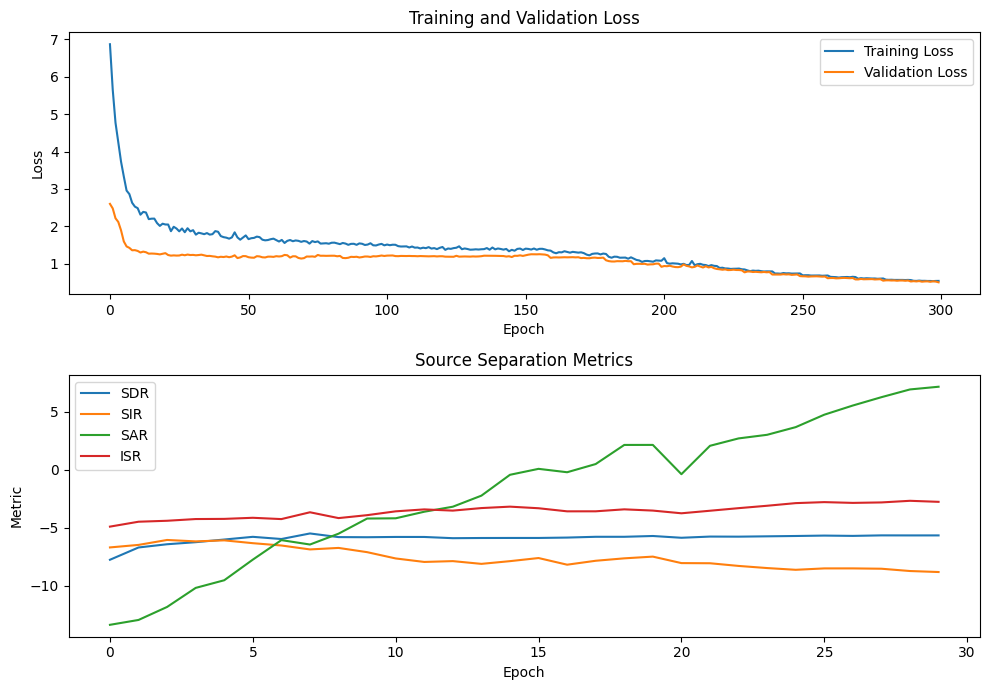

In [ ]:
def validate_model(model, dataloader, criterion, device, weights):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0  # Initialize total loss

    with torch.no_grad():  # Disable gradient computation
        for batch_idx, (data, targets) in enumerate(dataloader):
            data = inspect_and_prepare_data(data).to(device)  # Prepare and move data to device
            targets = inspect_and_prepare_data(targets, is_target=True).to(device)  # Prepare and move targets to device
            outputs = model(data)  # Get model outputs
            loss = criterion(outputs, targets, weights)  # Compute loss
            total_loss += loss.item()  # Accumulate loss

    avg_loss = total_loss / len(dataloader)  # Compute average loss
    print(f'Validation Loss: {avg_loss:.4f}')
    return avg_loss  # Return the average loss

def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, device, weights, loss_metric_mapping, epochs=10):
    train_losses = []  # List to store training losses
    valid_losses = []  # List to store validation losses
    metrics = {'sdr': [], 'sir': [], 'sar': [], 'isr': []}  # Dictionary to store metrics
    best_val_loss = float('inf')  # Initialize best validation loss

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0  # Initialize total training loss

        for batch_idx, (data, targets) in enumerate(train_loader):
            data = inspect_and_prepare_data(data).to(device)  # Prepare and move data to device
            targets = inspect_and_prepare_data(targets, is_target=True).to(device)  # Prepare and move targets to device

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(data)  # Get model outputs
            loss = criterion(outputs, targets, weights)  # Compute loss
            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Update the model parameters
            total_train_loss += loss.item()  # Accumulate training loss

        avg_train_loss = total_train_loss / len(train_loader)  # Compute average training loss
        train_losses.append(avg_train_loss)  # Append average training loss to the list
        print(f'Epoch {epoch+1}/{epochs}, Average Training Loss: {avg_train_loss:.4f}')  # Print average training loss

        # Every 10 epochs, compute metrics for training data
        if (epoch + 1) % 10 == 0:
            sdr, sir, sar, isr = [], [], [], []  # Initialize metrics lists
            try:
                model.eval()  # Set the model to evaluation mode for metric computation
                with torch.no_grad():
                    for batch_idx, (data, targets) in enumerate(train_loader):
                        data = inspect_and_prepare_data(data).to(device)  # Prepare and move data to device
                        targets = inspect_and_prepare_data(targets, is_target=True).to(device)  # Prepare and move targets to device

                        outputs = model(data)  # Get model outputs

                        for i in range(outputs.shape[0]):  # Iterate over the batch
                            # Invert the spectrogram to get audio
                            outputs_audio = [invert_spectrogram(outputs[i, s].unsqueeze(-1), device=device) for s in range(outputs.shape[1])]
                            targets_audio = [invert_spectrogram(targets[i, s].unsqueeze(-1), device=device) for s in range(targets.shape[1])]

                            est_segments = []  # Estimated segments for BSS Eval
                            ref_segments = []  # Reference segments for BSS Eval

                            for est, ref in zip(outputs_audio, targets_audio):
                                est = est.detach().cpu().numpy().flatten()  # Convert to numpy and flatten
                                ref = ref.detach().cpu().numpy().flatten()  # Convert to numpy and flatten

                                est_segments.append(est)  # Append estimated segment
                                ref_segments.append(ref)  # Append reference segment

                            if len(est_segments) == 0 or len(ref_segments) == 0:  # Skip if any segment is empty
                                continue

                            est_segments = np.stack(est_segments)  # Stack estimated segments
                            ref_segments = np.stack(ref_segments)  # Stack reference segments

                            # Adding epsilon to prevent division by zero
                            epsilon = 1e-8
                            sdr_vals, isr_vals, sir_vals, sar_vals, _ = mir_eval.separation.bss_eval_images(
                                ref_segments + epsilon, est_segments + epsilon, compute_permutation=False
                            )
                            sdr.extend(sdr_vals)  # Extend SDR values
                            isr.extend(isr_vals)  # Extend ISR values
                            sir.extend(sir_vals)  # Extend SIR values
                            sar.extend(sar_vals)  # Extend SAR values

            except Exception as e:
                print(f"Error processing track: {e}")  # Print error message

            # Compute average training metrics
            avg_sdr = np.mean(sdr) if sdr else float('nan')
            avg_sir = np.mean(sir) if sir else float('nan')
            avg_sar = np.mean(sar) if sar else float('nan')
            avg_isr = np.mean(isr) if isr else float('nan')
            metrics['sdr'].append(avg_sdr)  # Append average SDR
            metrics['sir'].append(avg_sir)  # Append average SIR
            metrics['sar'].append(avg_sar)  # Append average SAR
            metrics['isr'].append(avg_isr)  # Append average ISR

            print(f'Training Metrics after {epoch+1} epochs - SDR: {avg_sdr:.2f}, SIR: {avg_sir:.2f}, SAR: {avg_sar:.2f}, ISR: {avg_isr:.2f}')  # Print training metrics

            # Update weights using training metrics
            weights = update_weights(weights, metrics, loss_metric_mapping)

        # Compute validation loss
        validation_loss = validate_model(model, valid_loader, criterion, device, weights)
        valid_losses.append(validation_loss)  # Append validation loss

        # Update best model if validation loss improves
        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            torch.save(model.state_dict(), save_path)  # Save the model state

        # Step the learning rate scheduler
        scheduler.step()
        torch.cuda.empty_cache()
        gc.collect()  # Collect garbage

    # Plotting training and validation loss and metrics
    plt.figure(figsize=(10, 7))
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Training Loss')  # Plot training loss
    plt.plot(valid_losses, label='Validation Loss')  # Plot validation loss
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(metrics['sdr'], label='SDR')  # Plot SDR metric
    plt.plot(metrics['sir'], label='SIR')  # Plot SIR metric
    plt.plot(metrics['sar'], label='SAR')  # Plot SAR metric
    plt.plot(metrics['isr'], label='ISR')  # Plot ISR metric
    plt.title('Source Separation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.legend()
    plt.tight_layout()
    plt.show()


# Set the number of epochs
epoch_num = 300

# Set the device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = EnhancedUNet(in_channels=2, num_sources=4, dropout_prob=0.3).to(device)

# Define the loss criterion
criterion = custom_loss

# Initialize the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.01)

# Initialize the learning rate scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=epoch_num)

# Define the initial weights for the custom loss
initial_weights = {
    'spec_weight': 0.2,
    'mag_weight': 0.2,
    'phase_weight': 0.2,
    'interference_weight': 0.1,
    'artifacts_weight': 0.3
}

# Normalize the initial weights
initial_weights = normalize_weights(initial_weights)

# Map loss components to metrics for weight adjustment
loss_metric_mapping = {
    'spec_weight': 'sdr',
    'mag_weight': 'sir',
    'phase_weight': 'sar',
    'interference_weight': 'isr',
    'artifacts_weight': 'sar'
}


summary(model, input_size=(2, 513, 1292))
save_path = "/content/drive/MyDrive/musdb18/model_parameters.pt"
train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, device, initial_weights, loss_metric_mapping, epochs=epoch_num)

In [ ]:
# Specify the directory containing .pt files and the path to the new HDF5 file
pt_directory = '/content/drive/MyDrive/musdb18/test_spectrograms'
test_hdf5_path = '/content/drive/MyDrive/musdb18/test_spectrograms_hdf5'

# Convert the files
convert_pt_to_hdf5(pt_directory, test_hdf5_path)

In [ ]:
def evaluate_model(model, test_loader, device, num_sources, source_names):
    model.eval()  # Set the model to evaluation mode
    sample_rate = 22050
    epsilon = 1e-8

    # Initialize lists to store metrics for each source
    all_sdr = {source: [] for source in source_names}
    all_sir = {source: [] for source in source_names}
    all_sar = {source: [] for source in source_names}
    all_isr = {source: [] for source in source_names}

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(test_loader):
            data = inspect_and_prepare_data(data).to(device)
            targets = inspect_and_prepare_data(targets, is_target=True).to(device)

            # Forward pass
            outputs = model(data)

            for i in range(outputs.shape[0]):  # Iterate over each sample in the batch
                outputs_audio = [invert_spectrogram(outputs[i, s].unsqueeze(-1), device=device) for s in range(outputs.shape[1])]
                targets_audio = [invert_spectrogram(targets[i, s].unsqueeze(-1), device=device) for s in range(targets.shape[1])]

                est_segments = []  # Estimated segments for BSS Eval
                ref_segments = []  # Reference segments for BSS Eval

                for est, ref in zip(outputs_audio, targets_audio):
                    est = est.cpu().numpy().flatten()
                    ref = ref.cpu().numpy().flatten()

                    # Skip silent reference sources
                    if np.all(ref == 0):
                        continue

                    est_segments.append(est)
                    ref_segments.append(ref)

                if len(est_segments) == 0 or len(ref_segments) == 0:
                    continue

                est_segments = np.stack(est_segments)
                ref_segments = np.stack(ref_segments)

                try:
                    # Adding epsilon to prevent division by zero
                    sdr_vals, isr_vals, sir_vals, sar_vals, _ = mir_eval.separation.bss_eval_images(
                        ref_segments + epsilon, est_segments + epsilon, compute_permutation=False
                    )
                    for s, source in enumerate(source_names):
                        if s < len(sdr_vals):  # Ensure there are enough values to prevent index out of bounds
                            all_sdr[source].append(sdr_vals[s])
                            all_sir[source].append(sir_vals[s])
                            all_sar[source].append(sar_vals[s])
                            all_isr[source].append(isr_vals[s])
                except Exception as e:
                    print(f"Error processing track: {e}")

    # Compute average metrics for each source
    avg_sdr = {source: np.mean(all_sdr[source]) if all_sdr[source] else float('nan') for source in source_names}
    avg_sir = {source: np.mean(all_sir[source]) if all_sir[source] else float('nan') for source in source_names}
    avg_sar = {source: np.mean(all_sar[source]) if all_sar[source] else float('nan') for source in source_names}
    avg_isr = {source: np.mean(all_isr[source]) if all_isr[source] else float('nan') for source in source_names}

    for source in source_names:
        print(f'Source: {source} - Average SDR: {avg_sdr[source]:.2f}, Average SIR: {avg_sir[source]:.2f}, Average SAR: {avg_sar[source]:.2f}, Average ISR: {avg_isr[source]:.2f}')

    return avg_sdr, avg_sir, avg_sar, avg_isr


# Get the list of unique track base names from the HDF5 file
test_tracks = get_unique_track_names('/content/drive/MyDrive/musdb18/test_spectrograms_hdf5')

# Determine the total number of tracks to use
total_tracks = min(50, len(test_tracks))

# Define the path to the HDF5 file
test_hdf5_path = '/content/drive/MyDrive/musdb18/test_spectrograms_hdf5'

# Create training and validation datasets with the corresponding track names and transformations
test_dataset = AudioDataset(hdf5_path=test_hdf5_path, track_list=test_tracks, transform=None)

# Create DataLoader for the training dataset
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    collate_fn=pad_and_collate
)

source_names = ['bass', 'drums', 'other', 'vocals']  # Define the source names in order
num_sources = 4  # Define the number of sources in your dataset
evaluate_model(model, test_loader, device, num_sources, source_names)

Source: bass - Average SDR: 0.11, Average SIR: inf, Average SAR: 5.73, Average ISR: 0.15
Source: drums - Average SDR: 0.85, Average SIR: -5.74, Average SAR: 7.74, Average ISR: 1.29
Source: other - Average SDR: 1.66, Average SIR: -0.78, Average SAR: 7.69, Average ISR: 2.64
Source: vocals - Average SDR: 0.90, Average SIR: -5.51, Average SAR: 7.65, Average ISR: 1.47


({'bass': 0.11094596923192726,
  'drums': 0.846125513233099,
  'other': 1.656942784601498,
  'vocals': 0.9044294983168595},
 {'bass': inf,
  'drums': -5.742665774563841,
  'other': -0.7827459701417602,
  'vocals': -5.505653216220356},
 {'bass': 5.733983932535275,
  'drums': 7.736156682456919,
  'other': 7.692274948511468,
  'vocals': 7.654330429661234},
 {'bass': 0.14773192944209704,
  'drums': 1.2935064593542538,
  'other': 2.6351925735360635,
  'vocals': 1.4745686370063953})

In [ ]:
def evaluate_bass_sir(model, test_loader, device):
    model.eval()
    sample_rate = 22050
    epsilon = 1e-8

    all_sir = []  # Initialize list

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(test_loader):
            data = inspect_and_prepare_data(data).to(device)  # Prepare and move data to device
            targets = inspect_and_prepare_data(targets, is_target=True).to(device)  # Prepare and move targets to device

            outputs = model(data)

            for i in range(outputs.shape[0]):  # Iterate over each sample in the batch
                outputs_audio = [invert_spectrogram(outputs[i, s].unsqueeze(-1), device=device) for s in range(outputs.shape[1])]
                targets_audio = [invert_spectrogram(targets[i, s].unsqueeze(-1), device=device) for s in range(targets.shape[1])]

                est_segments = []  # Estimated segments for BSS Eval
                ref_segments = []  # Reference segments for BSS Eval

                for est, ref in zip(outputs_audio, targets_audio):
                    est = est.cpu().numpy().flatten()
                    ref = ref.cpu().numpy().flatten()

                    # Skip silent reference sources
                    if np.all(ref == 0) or np.all(est == 0):
                        continue

                    est_segments.append(est)
                    ref_segments.append(ref)

                if len(est_segments) == 0 or len(ref_segments) == 0:
                    continue

                est_segments = np.stack(est_segments)
                ref_segments = np.stack(ref_segments)

                try:
                    # Adding epsilon to prevent division by zero
                    sdr_vals, isr_vals, sir_vals, sar_vals, _ = mir_eval.separation.bss_eval_images(
                        ref_segments + epsilon, est_segments + epsilon, compute_permutation=False
                    )
                    for s, source in enumerate(source_names):
                        if s < len(sir_vals):  # Ensure there are enough values to prevent index out of bounds
                            if source == "bass":  # Check if the source is bass
                                if not np.isinf(sir_vals[s]):  # Skip inf values
                                    all_sir.append(sir_vals[s])
                except Exception as e:
                    print(f"Error processing track: {e}")

    avg_sir = np.mean(all_sir) if all_sir else float('nan')  # Compute average SIR for bass
    print(f'Bass - Average SIR: {avg_sir:.2f}')

    return avg_sir

avg_bass_sir = evaluate_bass_sir(model, test_loader, device)


Bass - Average SIR: -14.92
